<a href="https://www.kaggle.com/code/mikedelong/eda-with-map?scriptVersionId=137045132" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import pandas as pd
df = pd.read_csv(filepath_or_buffer='/kaggle/input/los-angeles-crime-dataset-2020-present/Crime_Data_from_2020_to_Present.csv', 
                 parse_dates=['Date Rptd', 'DATE OCC']).drop(columns=['DR_NO'])
df.sample(n=7)

,Date Rptd,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Part 1-2,Crm Cd,Crm Cd Desc,Mocodes,...,Status,Status Desc,Crm Cd 1,Crm Cd 2,Crm Cd 3,Crm Cd 4,LOCATION,Cross Street,LAT,LON
216856,2021-02-13,2021-02-12,1600,20,Olympic,2081,1,510,VEHICLE - STOLEN,NaN,...,IC,Invest Cont,510.0,NaN,NaN,NaN,WASHINGTON BL,GRAMERCY PL,34.0399,-118.3133
462551,2022-04-09,2022-04-08,2200,20,Olympic,2033,1,352,PICKPOCKET,0344 0377 1822 2032,...,IC,Invest Cont,352.0,NaN,NaN,NaN,3700 WILSHIRE BL,NaN,34.0617,-118.3066
433025,2022-04-01,2022-04-01,915,16,Foothill,1606,2,624,BATTERY - SIMPLE ASSAULT,0448 0340 1822,...,IC,Invest Cont,624.0,NaN,NaN,NaN,ELDRIDGE AV,LAUREL CANYON BL,34.2795,-118.3791
450815,2022-11-01,2022-11-01,330,7,Wilshire,762,2,626,INTIMATE PARTNER - SIMPLE ASSAULT,1814 0400 0416 2000,...,IC,Invest Cont,626.0,NaN,NaN,NaN,1500 LA CIENEGA BL,NaN,34.0507,-118.3762
723755,2023-02-13,2023-02-11,1415,9,Van Nuys,905,1,330,BURGLARY FROM VEHICLE,0344 1609 1307,...,IC,Invest Cont,330.0,NaN,NaN,NaN,KESTER AV,VALERIO ST,34.2048,-118.4575
605519,2022-10-02,2022-10-02,620,12,77th Street,1241,1,761,BRANDISH WEAPON,0913 0400 0334 0443 1814 2000,...,AO,Adult Other,761.0,930.0,NaN,NaN,3300 HYDE PARK BL,NaN,33.9806,-118.3294
242539,2021-08-10,2021-08-10,800,4,Hollenbeck,423,1,442,SHOPLIFTING - PETTY THEFT ($950 & UNDER),0344 0325 2004,...,IC,Invest Cont,442.0,NaN,NaN,NaN,SICHEL,ALHAMBRA,34.0637,-118.2128


In [2]:
df.columns

Index(['Date Rptd', 'DATE OCC', 'TIME OCC', 'AREA', 'AREA NAME', 'Rpt Dist No',
       'Part 1-2', 'Crm Cd', 'Crm Cd Desc', 'Mocodes', 'Vict Age', 'Vict Sex',
       'Vict Descent', 'Premis Cd', 'Premis Desc', 'Weapon Used Cd',
       'Weapon Desc', 'Status', 'Status Desc', 'Crm Cd 1', 'Crm Cd 2',
       'Crm Cd 3', 'Crm Cd 4', 'LOCATION', 'Cross Street', 'LAT', 'LON'],
      dtype='object')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


<Axes: xlabel='Vict Age', ylabel='Density'>

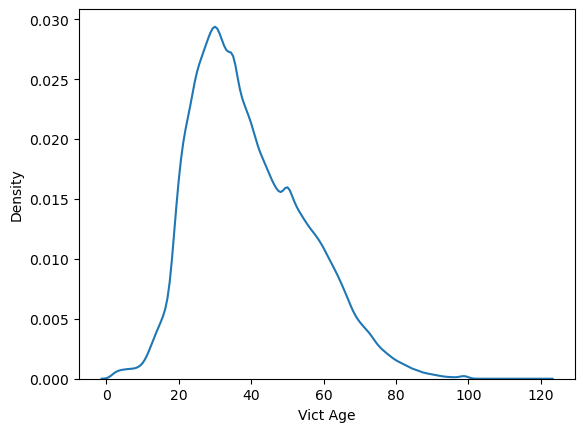

In [3]:
# let's look at some distributions
%matplotlib inline
from seaborn import kdeplot
# we need to drop ages = 0 to filter out unknowns
kdeplot(data=df[df['Vict Age'] > 0], x='Vict Age')

In [4]:
from folium import Map
from folium import Marker

sample_size = 1000
sample_df = df.sample(sample_size)

# for some reason we have to fudge the center a little
lon_fudge = -0.5
location_map = Map(location=[sample_df['LAT'].mean(), sample_df['LON'].mean() + lon_fudge], zoom_start=10)
for index, row in sample_df.iterrows():
    popup = '{}/{}/{}:{}'.format(row['LOCATION'], row['AREA NAME'], row['Crm Cd Desc'], row['Status'])
    Marker([row['LAT'], row['LON']], popup=popup).add_to(parent=location_map)

location_map

In [5]:
df.shape

(752911, 27)

In [6]:
df['Crm Cd'].nunique()

138

We have 138 codes; clearly we can't make sense of a pie with that many slices, so let's look at the top ten or so

In [7]:
crime_code_value_counts = df['Crm Cd Desc'].value_counts()
code_df = pd.DataFrame(data={'Code': crime_code_value_counts.index, 'Count': crime_code_value_counts.values}).reset_index(drop=True)
code_df.head(10)

,Code,Count
0,VEHICLE - STOLEN,80439
1,BATTERY - SIMPLE ASSAULT,59630
2,THEFT OF IDENTITY,48645
3,BURGLARY FROM VEHICLE,46526
4,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",46157
5,BURGLARY,45717
6,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",43149
7,THEFT PLAIN - PETTY ($950 & UNDER),38510
8,INTIMATE PARTNER - SIMPLE ASSAULT,37947
9,THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER),29310


In [8]:
import plotly.express as px
code_df.loc[code_df['Count'] < 15000, 'Code'] = 'Other' # we have too many codes so let's apply a threshold
px.pie(code_df, names='Code', values='Count').show()

In [9]:
# Surely the areas are shaped so the crime is roughly the same in each one; right?
area_value_counts = df['AREA NAME'].value_counts()
area_df = pd.DataFrame(data={'Area': area_value_counts.index, 'Count': area_value_counts.values}).reset_index(drop=True)
px.pie(area_df, names='Area', values='Count').show()

In [10]:
victim_descent = df['Vict Descent'].replace(to_replace={'B': 'Black', 'H': 'Hispanic', 'W': 'White',}).value_counts()
descent_df = pd.DataFrame(data={'Descent': victim_descent.index, 'Count': victim_descent.values}).reset_index(drop=True)
descent_df.loc[descent_df['Count'] < 80000, 'Descent'] = 'Other' # threshold
px.pie(descent_df, names='Descent', values='Count').show()